In [1]:
from zget_data import get_responses, get_qdetails, get_questions, page_map, quest_map
from collections import defaultdict
import pandas as pd
import json

In [2]:
survey_response, time_response = get_responses()

## Time Analysis

,index,1,2,3,4,5,6,7,csquest,spasssurvey,demo,total (mins)
0,47.704,8.317,5.774,20.529,3.303,35.736,6.323,62.769,1143.746,75.336,75.957,24.758233
1,40.725,5.459,4.329,25.462,4.268,33.700,2.059,51.148,897.312,51.163,75.270,19.848250
2,94.517,1.465,1.784,2.418,1.715,2.317,1.786,2.398,512.819,53.485,0.000,11.245067
3,63.538,11.205,3.537,25.954,3.870,22.020,7.220,79.719,1088.877,97.159,197.108,26.670117


20.63041666666667

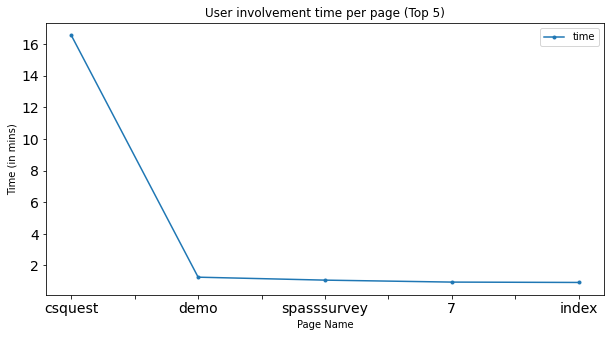

In [3]:
page_time_df = pd.DataFrame(time_response)
page_time_df = page_time_df.sort_index(axis=1, key=lambda x: x.astype(int))
page_time_df = page_time_df.rename(page_map, axis=1)
page_time_df['total (mins)'] = page_time_df.sum(axis=1)/60
display(page_time_df)
display(page_time_df['total (mins)'].mean())


# top 5 pages with higher time
top5 = pd.DataFrame(columns=['page', 'time'])
for i, data in page_time_df.median().div(60).sort_values(ascending=False).head(5).items():
    top5 = pd.concat([top5, pd.DataFrame([[i, data]], columns=top5.columns)])

_ = top5.plot(x='page', y='time', figsize=(10, 5), xlabel="Page Name", ylabel="Time (in mins)", title="User involvement time per page (Top 5)", fontsize=14, style=".-")

## Survey Response Analysis

In [4]:
questions = get_questions()
survey_response_df = pd.DataFrame(survey_response)
display(survey_response_df)

,8,9,0,10,null
0,"{'Sto': {'12-1': '2', '5-1': '6', '5-2': '5', ...","{'1-1': 'lrndsk!schl', '2-1': 'Strong', '3-1':...","{'1-1': ['Schoolwork', 'Assignments and homewo...","{'1-1': 'Boy', '2-1': '11 years old', '3-1': '...",NaN
1,"{'Sto': {'12-1': '1', '5-1': '7', '5-2': '7', ...","{'1-1': 'granddeep4810', '2-1': 'Very Strong',...","{'1-1': ['Games'], '2-1': '3 to 5 hours per day'}","{'1-1': 'Boy', '2-1': '8 years old', '3-1': '3...",NaN
2,"{'Cus': {'6-1': '4', '7-1': '5', '1-2': '5', '...","{'1-1': 'Iplayeddogfun6th', '2-1': 'Very Stron...","{'1-1': ['Schoolwork', 'Assignments and homewo...","{'1-1': 'Boy', '2-1': '11 years old', '3-1': '...","{'1-1': 'Boy', '2-1': '11 years old', '3-1': '..."
3,"{'Sto': {'12-1': '2', '5-1': '6', '5-2': '7', ...","{'1-1': 'JPawesome@8yrs', '2-1': 'Strong', '3-...","{'1-1': ['Assignments and homework', 'Games', ...","{'1-1': 'Boy', '2-1': '11 years old', '3-1': '...",NaN


In [5]:
normqsid = ['1-1', '1-2', '1-3', '1-4', '2-1', '3-1', '5-1', '5-2', '5-3', '5-4', '6-1', '7-1', '9-1', '10-1']
dnames = ['Sto', 'Cus', 'Bas']

normcolumns = [f'{qsid}_{dname}' for qsid in normqsid for dname in dnames]

def test(d):
    temp = {}
    for k, v in d.items():
        for k2, v2 in v.items():
            q = f'{k2}_{k}'
            temp[q] = v2
    return temp

csquest_response_df = survey_response_df['8'].apply(test)

In [6]:
csquest_design_df = pd.DataFrame(csquest_response_df.to_dict()).T
csquest_design_df

,12-1_Sto,5-1_Sto,5-2_Sto,5-3_Sto,5-4_Sto,9-1_Sto,10-1_Sto,2-1_Sto,3-1_Sto,6-1_Sto,...,10-1_Bas,11-1_Bas,1-3_Bas,1-1_Bas,1-2_Bas,1-4_Bas,13-1_Sto,8-1_Sto,11-1_Sto,4-1_Sto
0,2,6,5,7,6,5,7,4,5,5,...,7,3rd design because it shows how in different s...,4,5,6,7,NaN,NaN,NaN,NaN
1,1,7,7,5,7,7,7,7,4,7,...,7,3rd because it shows an example of it \nhappen...,7,4,5,7,NaN,NaN,NaN,NaN
2,2,1,3,2,1,7,2,7,5,7,...,7,NaN,5,5,5,4,The second one is the best because it shows ho...,Probably the first one cause that could happen...,Second one cause it shows the steps on how to ...,The first one is the best one for capturing my...
3,2,6,7,6,6,6,7,6,7,7,...,7,The third one is the best in understanding how...,6,4,5,6,NaN,NaN,NaN,NaN


In [7]:
csquest_quant_df = csquest_design_df[normcolumns].astype(int)
norm_csquest_quant_df = csquest_quant_df.sub(4)

In [8]:
norm_csquest_quant_df

,1-1_Sto,1-1_Cus,1-1_Bas,1-2_Sto,1-2_Cus,1-2_Bas,1-3_Sto,1-3_Cus,1-3_Bas,1-4_Sto,...,6-1_Bas,7-1_Sto,7-1_Cus,7-1_Bas,9-1_Sto,9-1_Cus,9-1_Bas,10-1_Sto,10-1_Cus,10-1_Bas
0,2,0,1,1,0,2,-1,1,0,3,...,1,3,3,3,1,1,1,3,3,3
1,1,2,0,3,3,1,3,-1,3,2,...,3,3,2,3,3,3,3,3,3,3
2,-2,1,1,0,1,1,-2,0,1,-2,...,0,3,1,2,3,0,2,-2,1,3
3,2,1,0,1,2,1,2,1,2,2,...,1,3,2,2,2,3,2,3,3,3


In [9]:
norm_sto_df = norm_csquest_quant_df.filter(like='Sto')
norm_cus_df = norm_csquest_quant_df.filter(like='Cus')
norm_bas_df = norm_csquest_quant_df.filter(like='Bas')

In [10]:
condition = '1-|5-'
new_norm_sto_df = norm_sto_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_sto_df.columns}
new_norm_sto_df = new_norm_sto_df.rename(columns=new_column_names)

temp = norm_sto_df.filter(like='1-')
new_norm_sto_df['1'] = temp.T.mean()

temp = norm_sto_df.filter(like='5-')
new_norm_sto_df['5'] = temp.T.mean()



# temp = norm_cus_df.filter(like='1-')
# temp.T.mean()

# temp = norm_bas_df.filter(like='1-')
# temp.T.mean()


# temp = norm_cus_df.filter(like='5-')
# temp.T.mean()

# temp = norm_bas_df.filter(like='5-')
# temp.T.mean()

display(new_norm_sto_df)


condition = '1-|5-'
new_norm_cus_df = norm_cus_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_cus_df.columns}
new_norm_cus_df = new_norm_cus_df.rename(columns=new_column_names)

temp = norm_cus_df.filter(like='1-')
new_norm_cus_df['1'] = temp.T.mean()

temp = norm_cus_df.filter(like='5-')
new_norm_cus_df['5'] = temp.T.mean()

display(new_norm_cus_df)


condition = '1-|5-'
new_norm_bas_df = norm_bas_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_bas_df.columns}
new_norm_bas_df = new_norm_bas_df.rename(columns=new_column_names)

temp = norm_bas_df.filter(like='1-')
new_norm_bas_df['1'] = temp.T.mean()

temp = norm_bas_df.filter(like='5-')
new_norm_bas_df['5'] = temp.T.mean()

display(new_norm_bas_df)


,2,3,6,7,9,10,1,5
0,0,1,1,3,1,3,1.25,2.00
1,3,0,3,3,3,3,2.25,2.50
2,3,1,3,3,3,-2,-1.50,-2.25
3,2,3,3,3,2,3,1.75,2.25


,2,3,6,7,9,10,1,5
0,1,0,1,3,1,3,0.75,2.00
1,2,1,3,2,3,3,1.75,2.25
2,0,0,0,1,0,1,0.50,0.75
3,2,2,1,2,3,3,1.50,3.00


,2,3,6,7,9,10,1,5
0,0,1,1,3,1,3,1.50,2.00
1,0,3,3,3,3,3,1.75,3.00
2,1,2,0,2,2,3,0.75,1.50
3,2,1,1,2,2,3,1.25,2.25


In [11]:
display(pd.DataFrame(new_norm_sto_df.mean()).T)
display(pd.DataFrame(new_norm_cus_df.mean()).T)
pd.DataFrame(new_norm_bas_df.mean()).T

,2,3,6,7,9,10,1,5
0,2.0,1.25,2.5,3.0,2.25,1.75,0.9375,1.125


,2,3,6,7,9,10,1,5
0,1.25,0.75,1.25,2.0,1.75,2.5,1.125,2.0


,2,3,6,7,9,10,1,5
0,0.75,1.75,1.25,2.5,2.0,3.0,1.3125,2.1875
